The image dataset that we have utilized consisted of 3 resolution types of images. We have selected 224 pixels resolution set and arranged them into test, train and validation folders for our convenience.

## References

[1] https://github.com/imamun93/animal-image-classifications/blob/master/final_notebook.ipynb 

[2] https://www.youtube.com/watch?v=kJreyh5Gh8c&ab_channel=A.I.Omary 

[3] https://github.com/whimian/SVM-Image-Classification/blob/master/Image%20Classification%20using%20scikit-learn.ipynb 

[4] https://medium.com/analytics-vidhya/image-classification-using-machine-learning-support-vector-machine-svm-dc7a0ec92e01 

### **Importing the Libraries**



In [ ]:
import keras
import PIL
import os
import cv2
import imutils
import numpy as np
import pandas as pd
import seaborn as sns
from keras.layers import Dense
from keras.models import load_model
from keras.applications import VGG16
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

from PIL import Image
from pathlib import Path
from PIL import UnidentifiedImageError
import matplotlib.pyplot as plt

from skimage.transform import resize
from skimage.io import imread
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


accuracies={}

## **Converting images to RGBA format.**
Note: Run the below code bit only if RGBA Files are not present.

In [ ]:
ty = ['train','test','valid']
classes = ['cheetah','fox','hyena','lion','tiger','wolf']
for i in range(len(ty)):
  for j in range(len(classes)):
    path = Path("/content/drive/MyDrive/Data/{}/{}".format(ty[i],classes[j])).rglob("*.png")
    for img_p in path:
      try:
        Image.open(img_p).convert('RGBA').save(img_p)
      except PIL.UnidentifiedImageError:
            print(img_p)
            os.remove(img_p)
            '''

'ty = [\'train\',\'test\',\'valid\']\nclasses = [\'cheetah\',\'fox\',\'hyena\',\'lion\',\'tiger\',\'wolf\']\nfor i in range(len(ty)):\n  for j in range(len(classes)):\n    path = Path("/content/drive/MyDrive/Data/{}/{}".format(ty[i],classes[j])).rglob("*.png")\n    for img_p in path:\n      try:\n        Image.open(img_p).convert(\'RGBA\').save(img_p)\n      except PIL.UnidentifiedImageError:\n            print(img_p)\n            os.remove(img_p)\n            '

In [ ]:
#Defining the classes in the image dataset
classes = ['cheetah','fox','hyena','lion','tiger','wolf']

In [ ]:
no_classes = 6
im_size = 224
batchsize_tr = 128
batchsize_val = 128

In [ ]:
#Creating an Image Data generator which can be utilized for directory iteration
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

## Train Data Generator Creation

In [ ]:
traingen = datagen.flow_from_directory('/content/drive/MyDrive/Data/train',target_size=(im_size,im_size),class_mode='categorical',batch_size=batchsize_tr)
tr_imgs=[]
tr_lbls=[]

for i in classes:
    tr_path = '/content/drive/MyDrive/Data/train/{}'.format(i)
    for f in os.listdir(tr_path):
        if f.split('.')[1] == 'png':
            img = imread(os.path.join(tr_path,f))
            img = resize(img,(224,224,3))
            tr_imgs.append(img.flatten())
            tr_lbls.append(classes.index(i))
       
      
tr_imgs = np.array(tr_imgs)
t=np.array(tr_imgs)
tgt=np.array(tr_lbls)
df_tr=pd.DataFrame(t) 
df_tr['Class']=tgt

x_train=df_tr.iloc[:,:-1]

y_train=df_tr.iloc[:,-1] 

Found 1387 images belonging to 6 classes.


## Validation Data Generator Creation

In [ ]:
valgen = datagen.flow_from_directory('/content/drive/MyDrive/Data/validation',batch_size=128,target_size=(im_size,im_size), class_mode='categorical')

val_imgs=[]
val_lbls=[]

for i in classes:
    val_path = '/content/drive/MyDrive/Data/validation/{}'.format(i)
    for f in os.listdir(val_path):
        if f.split('.')[1] == 'png':
            img = imread(os.path.join(val_path,f))
            img = resize(img,(224,224,3))

            val_lbls.append(classes.index(i))
            val_imgs.append(img.flatten())
       
      
val_imgs = np.array(val_imgs)
t=np.array(val_imgs)
tgt=np.array(val_lbls)
df_val=pd.DataFrame(t) 
df_val['Class']=tgt


x_valid=df_val.iloc[:,:-1] 

y_valid=df_val.iloc[:,-1]

Found 172 images belonging to 6 classes.


## Test Data Generator Creation

In [ ]:
test_imgs=[]
test_lbls=[]
test_pred_imgs=[]
testgen=datagen.flow_from_directory('/content/drive/MyDrive/Data/test',shuffle=False, target_size=(im_size,im_size))
for i in classes:
    testpath = '/content/drive/MyDrive/Data/test/{}'.format(i)
    for f in os.listdir(testpath):
        if f.split('.')[1] == 'png':
            img = imread(os.path.join(testpath,f))
            test_pred_imgs.append(img)
            img = resize(img,(224,224,3))
            
            test_lbls.append(classes.index(i))
            test_imgs.append(img.flatten())
            
      
test_imgs = np.array(test_imgs)
epoch_test=len(testgen)
t=np.array(test_imgs)
tgt=np.array(test_lbls)
df_test=pd.DataFrame(t)
df_test['Class']=tgt

x_test=df_test.iloc[:,:-1] 

y_test=df_test.iloc[:,-1]

Found 174 images belonging to 6 classes.


### **VGG16 Image Classifier Construction**

In [ ]:
vgg16model=Sequential()

In [ ]:
#Creating VGG16 model with imagenet database weights
vgg16model.add(VGG16(include_top=False,weights='imagenet',pooling='avg'))

In [ ]:
#Layers of the VGG16 model
vgg16model.add(Dense(no_classes,activation='softmax'))
vgg16model.layers[0].layers

In [ ]:
vgg16model.layers[0].trainable=False

#Compiling the model with appropriate hyperparameters
vgg16model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

epoch_tr = len(traingen)
epoch_val = len(valgen)

epochs=10

In [ ]:
#Fitting the model
vgg16hist = vgg16model.fit(traingen,steps_per_epoch=epoch_tr,epochs=epochs,verbose=1,validation_data=valgen,validation_steps=epoch_val)

Epoch 1/10
11/11 [==============================] - 55s 5s/step - loss: 5.7565 - accuracy: 0.3425 - val_loss: 3.3324 - val_accuracy: 0.5174
Epoch 2/10
11/11 [==============================] - 52s 5s/step - loss: 2.5741 - accuracy: 0.5595 - val_loss: 1.3439 - val_accuracy: 0.7558
Epoch 3/10
11/11 [==============================] - 52s 5s/step - loss: 1.1448 - accuracy: 0.7505 - val_loss: 0.7457 - val_accuracy: 0.8372
Epoch 4/10
11/11 [==============================] - 51s 4s/step - loss: 0.6649 - accuracy: 0.8349 - val_loss: 0.4851 - val_accuracy: 0.9070
Epoch 5/10
11/11 [==============================] - 50s 4s/step - loss: 0.4492 - accuracy: 0.8767 - val_loss: 0.3983 - val_accuracy: 0.9186
Epoch 6/10
11/11 [==============================] - 51s 5s/step - loss: 0.3429 - accuracy: 0.9092 - val_loss: 0.3613 - val_accuracy: 0.9186
Epoch 7/10
11/11 [==============================] - 52s 5s/step - loss: 0.2699 - accuracy: 0.9207 - val_loss: 0.3058 - val_accuracy: 0.9244
Epoch 8/10
11/11 [==

In [ ]:
#Saving the model as .h5 file
vgg16model.save('/content/drive/MyDrive/Data/vgg16model.h5')

In [ ]:
vgg16model = load_model('/content/drive/MyDrive/Data/vgg16model.h5')

In [ ]:
#Predicting using test data generator

prediction=vgg16model.predict(testgen,steps=epoch_test,verbose=1)

6/6 [==============================] - 7s 1s/step


In [ ]:
y_pred=[]
for i in range(len(prediction)):
  y_pred.append(np.argmax(prediction[i]))

y_pred=pd.Series(y_pred)

acc=accuracy_score(y_pred,y_test)
print('Predicted accuracy:',acc)
accuracies['VGG16']=acc

Predicted accuracy: 0.9137931034482759


In [ ]:
#Printing the classification report
#print(classification_report(y_pred,y_test))

cr=classification_report(y_pred,y_test,output_dict=True)
dfvgg16 = pd.DataFrame(cr).T.reset_index()
dfvgg16

,index,precision,recall,f1-score,support
0,0,0.914286,0.941176,0.927536,34.000000
1,1,0.960000,0.923077,0.941176,26.000000
2,2,0.903226,0.965517,0.933333,29.000000
3,3,0.866667,0.812500,0.838710,32.000000
4,4,0.962963,0.928571,0.945455,28.000000
5,5,0.884615,0.920000,0.901961,25.000000
6,accuracy,0.913793,0.913793,0.913793,0.913793
7,macro avg,0.915293,0.915140,0.914695,174.000000
8,weighted avg,0.914086,0.913793,0.913413,174.000000


Class Type Predicted: cheetah


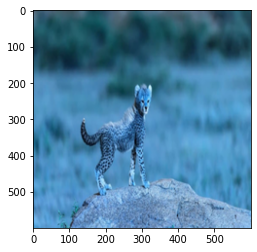

Class Type Predicted: cheetah


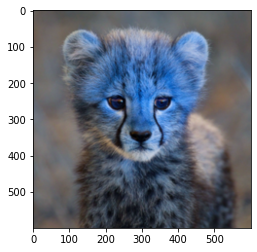

Class Type Predicted: cheetah


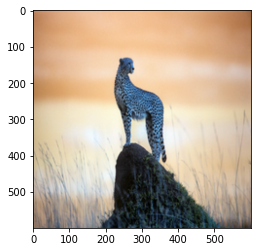

Class Type Predicted: cheetah


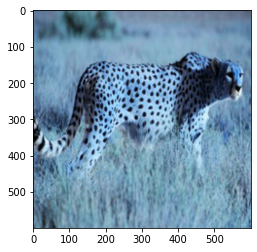

Class Type Predicted: cheetah


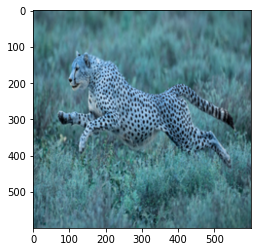

Class Type Predicted: cheetah


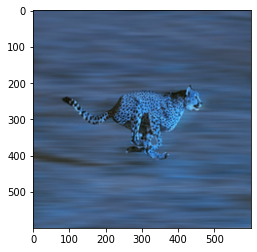

In [ ]:
#Printing first 6 images and their respective predictions from test data
for i in range(6):
  print("Class Type Predicted:",classes[np.argmax(prediction[i])])
  img = test_pred_imgs[i]
  img = imutils.resize(img, width=600)
  (h, w) = img.shape[:2]

  implot = plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB).astype('uint8'))
  plt.show()

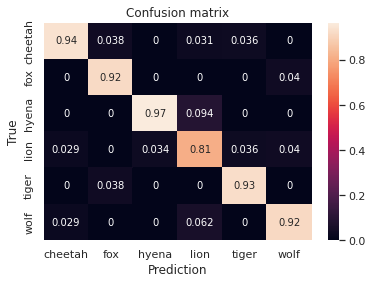

In [ ]:
res = confusion_matrix(y_test, y_pred , normalize='pred')
cm = pd.DataFrame(res, classes, classes)
sns.set(font_scale=1)
ax=plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 10})
ax.set_xlabel('Prediction');ax.set_ylabel('True'); 
ax.set_title('Confusion matrix'); 
plt.show()


### **Support Vector Machine Classifier**

In [ ]:
import pickle

svmmodel = svm.SVC(kernel='rbf', random_state = 32)
svmhist = svmmodel.fit(x_train,pd.Series(y_train))

#Saving the model as pickle file
with open('/content/drive/MyDrive/Data/svmmodel.pkl','wb') as f:
    pickle.dump(svmmodel,f)

In [ ]:
with open('/content/drive/MyDrive/Data/svmmodel.pkl', 'rb') as f:
    svmmodel = pickle.load(f)

y_pred=svmmodel.predict(x_test)
acc=accuracy_score(y_pred,y_test)
print('Predicted accuracy:',acc)
accuracies['SVM']=acc

Predicted accuracy: 0.3218390804597701


In [ ]:
#Printing the classification report
cr=classification_report(y_pred,y_test,output_dict=True)
dfsvm = pd.DataFrame(cr).T.reset_index()
dfsvm

,index,precision,recall,f1-score,support
0,0,0.485714,0.269841,0.346939,63.000000
1,1,0.200000,0.263158,0.227273,19.000000
2,2,0.161290,0.208333,0.181818,24.000000
3,3,0.233333,0.388889,0.291667,18.000000
4,4,0.259259,0.304348,0.280000,23.000000
5,5,0.576923,0.555556,0.566038,27.000000
6,accuracy,0.321839,0.321839,0.321839,0.321839
7,macro avg,0.319420,0.331687,0.315622,174.000000
8,weighted avg,0.367878,0.321839,0.330529,174.000000


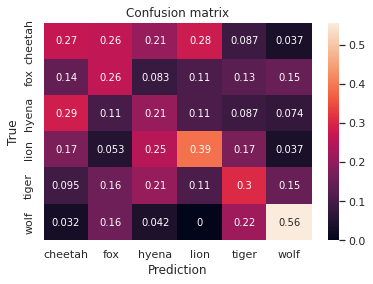

In [ ]:
res = confusion_matrix(y_test, y_pred , normalize='pred')
cm = pd.DataFrame(res, classes, classes)
sns.set(font_scale=1)
ax=plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 10})
ax.set_xlabel('Prediction');ax.set_ylabel('True'); 
ax.set_title('Confusion matrix'); 
plt.show()


### **Random Forest Classifier**

In [ ]:
rfmodel = RandomForestClassifier(n_estimators=90)

rfhist = rfmodel.fit(x_train,pd.Series(y_train))

#Saving the model as pickle file
with open('/content/drive/MyDrive/Data/rfmodel.pkl','wb') as f:
    pickle.dump(rfmodel,f)

In [ ]:
with open('/content/drive/MyDrive/Data/rfmodel.pkl', 'rb') as f:
    rfmodel = pickle.load(f)

y_pred = rfmodel.predict(x_test)
acc=accuracy_score(y_pred,y_test)
print('Predicted accuracy:',acc)
accuracies['RandomForest']=acc

Predicted accuracy: 0.39655172413793105


In [ ]:
#Printing the classification report
cr=classification_report(y_pred,y_test,output_dict=True)
dfrf = pd.DataFrame(cr).T.reset_index()
dfrf

,index,precision,recall,f1-score,support
0,0,0.571429,0.384615,0.459770,52.000000
1,1,0.120000,0.230769,0.157895,13.000000
2,2,0.354839,0.366667,0.360656,30.000000
3,3,0.400000,0.363636,0.380952,33.000000
4,4,0.185185,0.333333,0.238095,15.000000
5,5,0.692308,0.580645,0.631579,31.000000
6,accuracy,0.396552,0.396552,0.396552,0.396552
7,macro avg,0.387293,0.376611,0.371491,174.000000
8,weighted avg,0.456085,0.396552,0.416679,174.000000


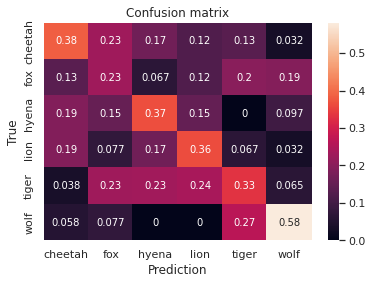

In [ ]:
res = confusion_matrix(y_test, y_pred , normalize='pred')
cm = pd.DataFrame(res, classes, classes)
sns.set(font_scale=1)
ax=plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 10})
ax.set_xlabel('Prediction');ax.set_ylabel('True'); 
ax.set_title('Confusion matrix'); 
plt.show()


### **K Nearest Neighbors Classifier**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knnmodel=KNeighborsClassifier(n_neighbors=40)
knnhist = knnmodel.fit(x_train,y_train)

#Saving the model as pickle (.pkl) file
with open('/content/drive/MyDrive/Data/knnmodel.pkl','wb') as f:
    pickle.dump(knnmodel,f)

In [ ]:
with open('/content/drive/MyDrive/Data/knnmodel.pkl', 'rb') as f:
    knnmodel = pickle.load(f)

y_pred = knnmodel.predict(x_test)
acc=accuracy_score(y_pred,y_test)
print('Predicted accuracy:',acc)
accuracies['KNN']=acc

Predicted accuracy: 0.28735632183908044


In [ ]:
#Printing the classification report
cr=classification_report(y_pred,y_test,output_dict=True)
dfknn = pd.DataFrame(cr).T.reset_index()
dfknn

,index,precision,recall,f1-score,support
0,0,0.600000,0.287671,0.388889,73.000000
1,1,0.440000,0.250000,0.318841,44.000000
2,2,0.225806,0.200000,0.212121,35.000000
3,3,0.133333,0.571429,0.216216,7.000000
4,4,0.037037,0.166667,0.060606,6.000000
5,5,0.230769,0.666667,0.342857,9.000000
6,accuracy,0.287356,0.287356,0.287356,0.287356
7,macro avg,0.277824,0.357072,0.256588,174.000000
8,weighted avg,0.426987,0.287356,0.314971,174.000000


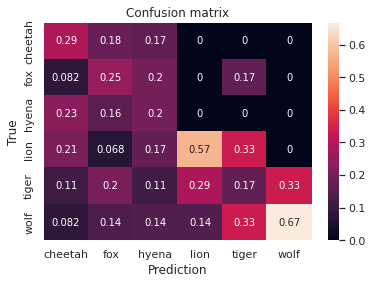

In [ ]:
res = confusion_matrix(y_test, y_pred , normalize='pred')
cm = pd.DataFrame(res, classes, classes)
sns.set(font_scale=1)
ax=plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 10})
ax.set_xlabel('Prediction');ax.set_ylabel('True'); 
ax.set_title('Confusion matrix'); 
plt.show()


### **Multinomial Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnbmodel=MultinomialNB()
mnbhist = mnbmodel.fit(x_train,y_train)

#Saving the model as pickle (.pkl) file
with open('/content/drive/MyDrive/Data/mnbmodel.pkl','wb') as f:
    pickle.dump(mnbmodel,f)

In [ ]:
with open('/content/drive/MyDrive/Data/mnbmodel.pkl', 'rb') as f:
    mnbmodel = pickle.load(f)

y_pred = mnbmodel.predict(x_test)
acc=accuracy_score(y_pred,y_test)
print('Predicted accuracy:',acc)
accuracies['MultinomialNB']=acc

Predicted accuracy: 0.28160919540229884


In [ ]:
#Printing the classification report
cr=classification_report(y_pred,y_test,output_dict=True)
dfmnb = pd.DataFrame(cr).T.reset_index()
dfmnb

,index,precision,recall,f1-score,support
0,0,0.371429,0.295455,0.329114,44.000000
1,1,0.000000,0.000000,0.000000,3.000000
2,2,0.225806,0.269231,0.245614,26.000000
3,3,0.133333,0.129032,0.131148,31.000000
4,4,0.481481,0.282609,0.356164,46.000000
5,5,0.461538,0.500000,0.480000,24.000000
6,accuracy,0.281609,0.281609,0.281609,0.281609
7,macro avg,0.278931,0.246054,0.257007,174.000000
8,weighted avg,0.342369,0.281609,0.303656,174.000000


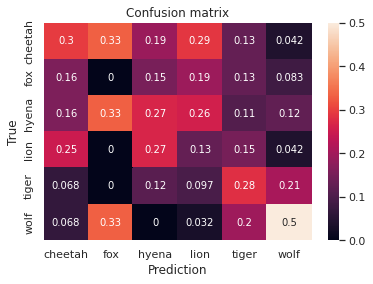

In [ ]:
res = confusion_matrix(y_test, y_pred , normalize='pred')
cm = pd.DataFrame(res, classes, classes)
sns.set(font_scale=1)
ax=plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 10})
ax.set_xlabel('Prediction');ax.set_ylabel('True'); 
ax.set_title('Confusion matrix'); 
plt.show()


### **Plotting the metrics of the constructed Models**

Plotting the History of VGG16 Model

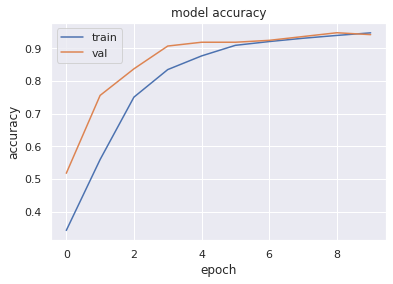

In [ ]:
plt.plot(vgg16hist.history['accuracy'])
plt.plot(vgg16hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Comparing accuracies of all the models.

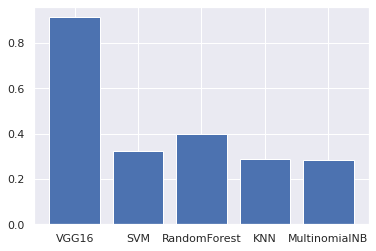

In [ ]:
n = list(accuracies.keys())
v = list(accuracies.values())

plt.bar(range(len(accuracies)), v, tick_label=n)
plt.show()

###Sub-plotting the Precision of all the models

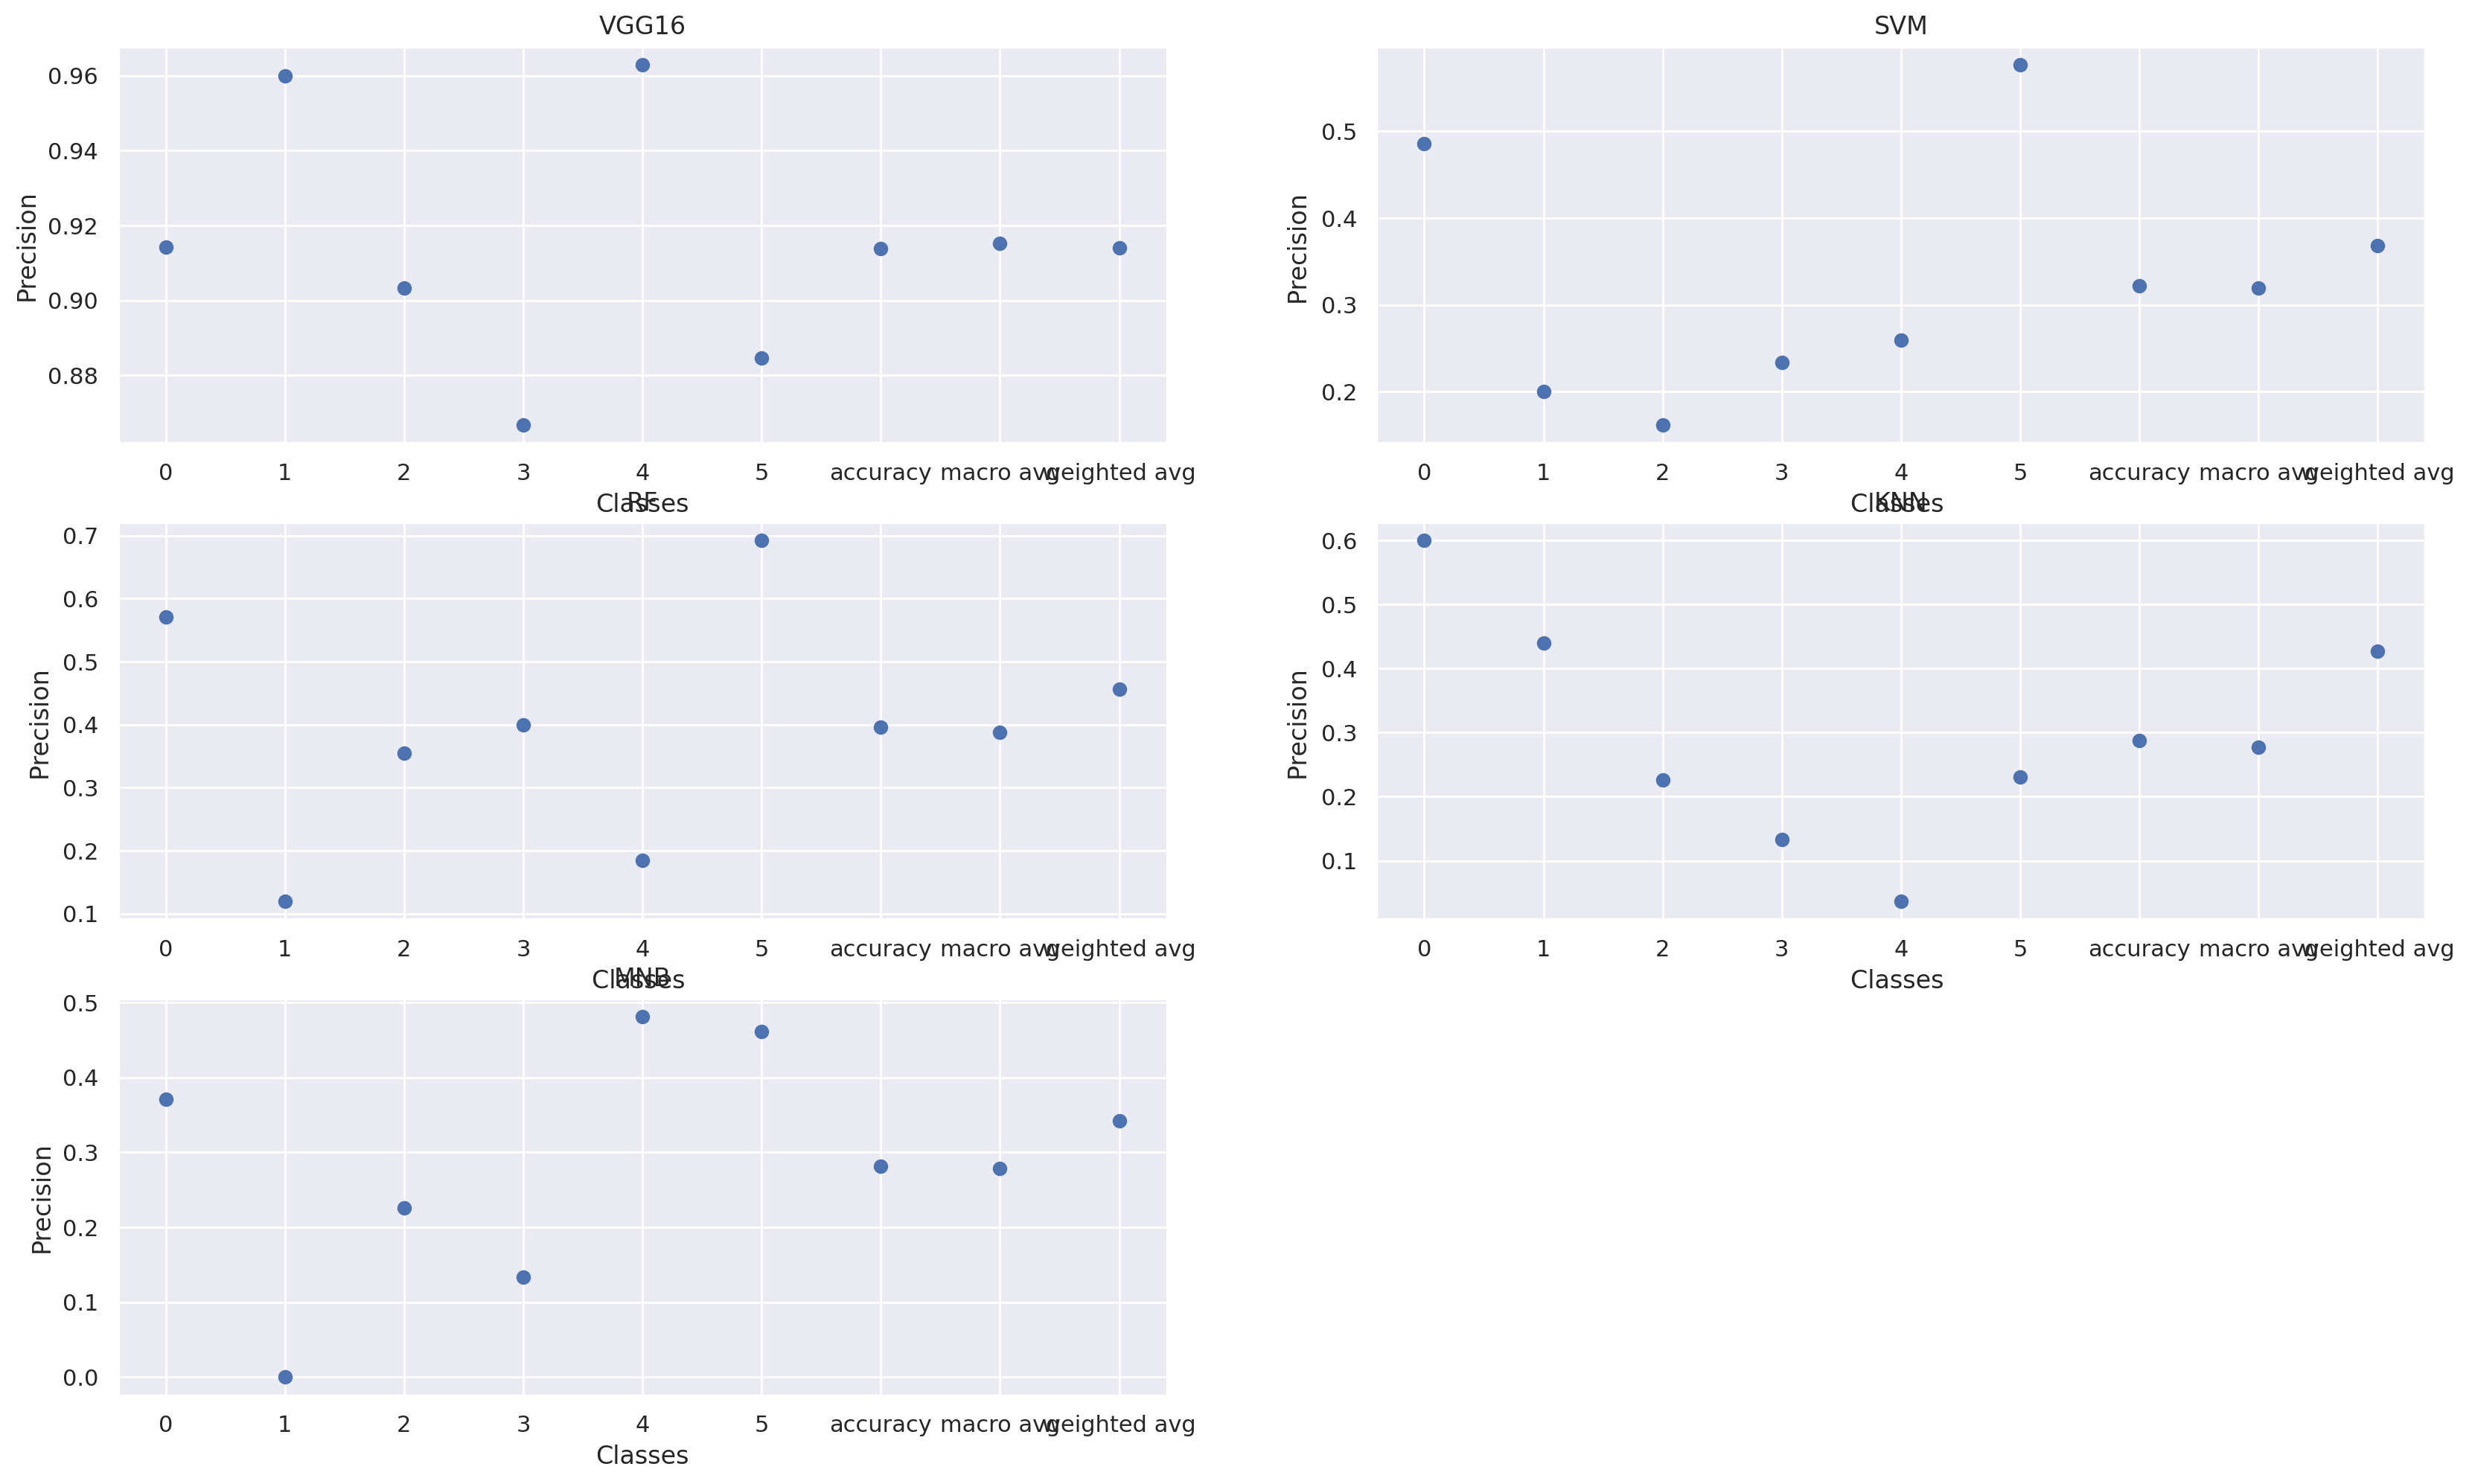

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(20, 12), dpi=200)

plt.subplot(3,2,1)
plt.scatter(dfvgg16['index'],  dfvgg16['precision'])
plt.title("VGG16")
plt.xlabel('Classes')
plt.ylabel('Precision')

plt.subplot(3,2,2)
plt.scatter(dfsvm['index'], dfsvm['precision'])
plt.title("SVM")
plt.xlabel('Classes ')
plt.ylabel('Precision ')

plt.subplot(3, 2,3)
plt.scatter(dfrf['index'], dfrf['precision'])
plt.title("RF")
plt.xlabel('Classes ')
plt.ylabel('Precision ')

plt.subplot(3, 2,4)
plt.scatter(dfknn['index'], dfknn['precision'])
plt.title("KNN")
plt.xlabel('Classes ')
plt.ylabel('Precision ')

plt.subplot(3, 2,5)
plt.scatter(dfmnb['index'], dfmnb['precision'])
plt.title("MNB")
plt.xlabel('Classes')
plt.ylabel('Precision')


plt.show()